In [1]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../../code/data_processing/name_resolution/")
from resolved_names_curator import ResolvedNamesCurator

import matplotlib.pyplot as plt
from ete3 import Tree

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
polyploidy_threshold = 0.75
diploidy_threshold = 0.25

ploidb_path = f"/groups/itay_mayrose/halabikeren/PloiDB/chromevol/database/ploidb_by_genus_without_missing.csv"
qdb_path = "/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/cvalues_db.csv"

unresolved_plant_names_path = f"../../data/name_resolution/unresolved_plant_names.csv"
resolved_plant_names_path = f"../../data/name_resolution/resolved_plant_names.csv"
resolved_pollinator_names_path = f"../../data/name_resolution/resolved_pollinator_names.csv"

tree_path = "../../data/trees/ALLMB.tre"
ccdb_path = "/groups/itay_mayrose/halabikeren/PloiDB/ccdb/all_data_with_ALLMB_mapped_names.csv"
classification_data_path = "/groups/itay_mayrose/halabikeren/PloiDB/trees/wfo_classification_data.csv"
missing_names_path = "/groups/itay_mayrose/halabikeren/PloiDB/trees/names_to_add_for_ppn_project.csv"

networks_types = ["weighted", "binary", "binarized_weighted"]
all_networks_dir = "/groups/itay_mayrose/halabikeren/plant_pollinator_networks/networks/all/"

plant_classification_path = f"../../data/ploidy_classification/plant_classification.csv"
network_classification_path = f"../../data/ploidy_classification/network_classification.csv"

all_networks_dir = "../../data/networks/all/"

# Examine coverage in kew-DB

In [ ]:
kew_db = pd.read_csv(qdb_path)
resolved_names = pd.read_csv(resolved_plant_names_path)

In [ ]:
kew_db["taxon"] = (kew_db["Genus"] + " " + kew_db["Species"] + kew_db["Subspecies"].replace({np.nan: ""})).str.lower()

In [ ]:
kew_db["is_polyploid"] = kew_db["Ploidy Level (x)"].apply(lambda l: np.nan if l == "-" else int(int(l) > 2))
kew_db = kew_db.dropna(subset=["is_polyploid"]).drop_duplicates(subset=["taxon"])
kew_db.shape[0]

In [ ]:
kew_based_classification = resolved_names
kew_based_classification["is_polyploid"] = np.nan
kew_based_classification.set_index("resolved_name", inplace=True)
kew_based_classification["is_polyploid"].fillna(value=kew_db.set_index("taxon")["is_polyploid"].to_dict(), inplace=True)
kew_based_classification.reset_index(inplace=True)
kew_based_classification.set_index("original_name", inplace=True)                                                
kew_based_classification["is_polyploid"].fillna(value=kew_db.set_index("taxon")["is_polyploid"].to_dict(), inplace=True)
kew_db.reset_index(inplace=True)
kew_based_classification.reset_index(inplace=True)

In [ ]:
kew_based_classification = kew_based_classification.drop_duplicates(subset=["original_name"])

In [ ]:
kew_based_classification.notna().sum()

In [ ]:
kew_based_classification.notna().sum() / kew_based_classification.shape[0] * 100

In [10]:
len(set(kew_db.set_index("taxon")["is_polyploid"].to_dict().keys()) & set(resolved_names.original_name))

399

In [11]:
len(set(kew_db.set_index("taxon")["is_polyploid"].to_dict().keys()) & set(resolved_names.resolved_name))

369

# Extract classification at plant species level

In [3]:
plant_classification_df = pd.read_csv(resolved_plant_names_path)[["original_name","matched_name", "resolved_name"]]
plant_classification_df.original_name = plant_classification_df.original_name.str.lower()
plant_classification_df.matched_name = plant_classification_df.matched_name.str.lower()
plant_classification_df.resolved_name = plant_classification_df.resolved_name.str.lower()

ploidy_df = pd.read_csv(ploidb_path)
ploidy_df["Ploidy inference"] = ploidy_df["Ploidy transitions frequency"].apply(lambda f: 1 if f >= polyploidy_threshold else (0 if f < diploidy_threshold else np.nan))
convervative_classification_data = ploidy_df.set_index("Taxon")["Ploidy inference"].to_dict()
convervative_age_data = ploidy_df.set_index("Taxon")["Ploidy age"].to_dict()


plant_classification_df.set_index("original_name", inplace=True)
plant_classification_df["is_polyploid_by_original"] = np.nan
plant_classification_df["polyploid_age_by_original"] = np.nan
plant_classification_df["is_polyploid_by_original"].fillna(value=convervative_classification_data, inplace=True)
plant_classification_df["polyploid_age_by_original"].fillna(value=convervative_age_data, inplace=True)
plant_classification_df.reset_index(inplace=True)

plant_classification_df.set_index("matched_name", inplace=True)
plant_classification_df["is_polyploid_by_matched"] = np.nan
plant_classification_df["polyploid_age_by_matched"] = np.nan
plant_classification_df["is_polyploid_by_matched"].fillna(value=convervative_classification_data, inplace=True)
plant_classification_df["polyploid_age_by_matched"].fillna(value=convervative_age_data, inplace=True)
plant_classification_df.reset_index(inplace=True)

plant_classification_df.set_index("resolved_name", inplace=True)
plant_classification_df["is_polyploid_by_resolved"] = np.nan
plant_classification_df["polyploid_age_by_resolved"] = np.nan
plant_classification_df["is_polyploid_by_resolved"].fillna(value=convervative_classification_data, inplace=True)
plant_classification_df["polyploid_age_by_resolved"].fillna(value=convervative_age_data, inplace=True)
plant_classification_df.reset_index(inplace=True)

In [4]:
plant_classification_df["is_polyploid"] = plant_classification_df[["is_polyploid_by_original",
                                                                                "is_polyploid_by_matched",
                                                                                "is_polyploid_by_resolved"]].apply(lambda labels: np.nan if len(labels.dropna())==0 else labels.dropna()[0], axis=1) 

plant_classification_df["polyploid_age"] = plant_classification_df[["polyploid_age_by_original",
                                                                                "polyploid_age_by_matched",
                                                                                "polyploid_age_by_resolved"]].apply(lambda labels: np.nan if len(labels.dropna())==0 else labels.dropna()[0], axis=1) 

In [5]:
print(f"% classified by original name = {np.round(plant_classification_df.dropna(subset=['is_polyploid_by_original']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['is_polyploid_by_original']).shape[0]:,})")

print(f"% classified by matched name = {np.round(plant_classification_df.dropna(subset=['is_polyploid_by_matched']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['is_polyploid_by_matched']).shape[0]:,})")

print(f"% classified by resolved name = {np.round(plant_classification_df.dropna(subset=['is_polyploid_by_resolved']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['is_polyploid_by_resolved']).shape[0]:,})")

print(f"% classified by any name = {np.round(plant_classification_df.dropna(subset=['is_polyploid']).shape[0]/plant_classification_df.shape[0]*100, 2)}% ({plant_classification_df.dropna(subset=['is_polyploid']).shape[0]:,})")

% classified by original name = 31.09% (1,626)
% classified by matched name = 0.0% (0)
% classified by resolved name = 32.83% (1,717)
% classified by any name = 34.47% (1,803)


In [6]:
avail_plant_classification_df = plant_classification_df.query("is_polyploid.notna()")
avail_plant_classification_df.to_csv(plant_classification_path, index=False)

# assign ploidy ages to diploid taxa

In [7]:
plant_classification = pd.read_csv(plant_classification_path)

In [8]:
diploids_for_age_classification = plant_classification.query("polyploid_age.isna() and is_polyploid.notna()")
print(f"# diploids for which ploidy age classification is required = {diploids_for_age_classification.shape[0]:,}")

# diploids for which ploidy age classification is required = 1


<AxesSubplot: >

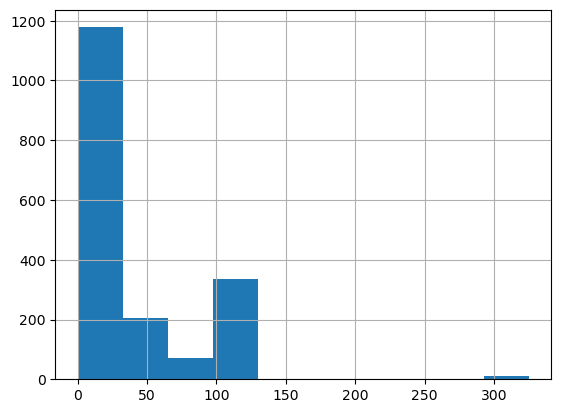

In [9]:
plant_classification.polyploid_age.hist()

In [10]:
plant_classification.polyploid_age.isna().sum()

1

# report ploidy classification stats

In [11]:
print(f"by resolved names")
debug = pd.read_csv(plant_classification_path)
print(f"% polyploids = {np.round(debug.loc[debug.is_polyploid_by_resolved == 1].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.is_polyploid_by_resolved == 1].shape[0]:,})")
print(f"% diploids = {np.round(debug.loc[debug.is_polyploid_by_resolved == 0].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.is_polyploid_by_resolved == 0].shape[0]:,})")
print(f"% undetermined = {np.round(debug.loc[debug.is_polyploid_by_resolved.isna()].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.is_polyploid_by_resolved.isna()].shape[0]:,})")

by resolved names
% polyploids = 34.89% (629)
% diploids = 60.34% (1,088)
% undetermined = 4.77% (86)


In [12]:
print(f"by original names")
print(f"% polyploids = {np.round(debug.loc[debug.is_polyploid_by_original == 1].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.is_polyploid_by_original == 1].shape[0]:,})")
print(f"% diploids = {np.round(debug.loc[debug.is_polyploid_by_original == 0].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.is_polyploid_by_original == 0].shape[0]:,})")
print(f"% undetermined = {np.round(debug.loc[debug.is_polyploid_by_original.isna()].shape[0]/debug.shape[0]*100,2)}% ({debug.loc[debug.is_polyploid_by_original.isna()].shape[0]:,})")

by original names
% polyploids = 33.67% (607)
% diploids = 56.52% (1,019)
% undetermined = 9.82% (177)


In [13]:
species_names_dfs = []
for networks_type in networks_types:
    networks_dir = f"../../data/networks/all/{networks_type}/"
    for path in os.listdir(networks_dir):
        if path.endswith(".csv"):
            try:
                network_path = f"{networks_dir}{path}"
                network = pd.read_csv(network_path)
                if not "Plant" in network.columns:
                    network = network.rename(columns={"Unnamed: 0": "Plant"})
                    network.to_csv(network_path)
                network_species = pd.DataFrame(columns=["network_type", "network_id", "original_name"])
                network_species["original_name"] = network.Plant.tolist()
                network_species["network_type"] = networks_type
                network_species["network_id"] = int(path.replace(".csv", ""))
                species_names_dfs.append(network_species)
            except Exception as e:
                print(f"error {e} for {path}")
                continue
features_by_network = pd.concat(species_names_dfs)
features_by_network.original_name = features_by_network.original_name.str.lower()
features_by_network.original_name = features_by_network.original_name.apply(lambda name: name.replace("_", " "))
features_by_network = features_by_network.merge(plant_classification_df[["original_name", "is_polyploid", "polyploid_age"]], on="original_name", how="left")

In [14]:
def get_poly_frac(labels):
    poly = (labels == 1).sum()
    di = (labels == 0).sum()
    return poly/(di+poly)

def get_missing_frac(labels):
    missing = (labels.isna()).sum()
    return missing/len(labels)         

network_classification = features_by_network.groupby(["network_type", "network_id"]).agg({"is_polyploid": [get_poly_frac, get_missing_frac]}).reset_index()
network_classification.columns = [f"{c[0]}{c[1].replace('get','')}" for c in network_classification.columns]

network_classification = network_classification.fillna(0)

/tmp/ipykernel_12632/2653682608.py:4: RuntimeWarning: invalid value encountered in long_scalars
  return poly/(di+poly)


In [15]:
network_classification.to_csv(network_classification_path, index=False)

# fill network coverage as metadata

In [16]:
network_classification = pd.read_csv(network_classification_path)
plant_classification = pd.read_csv(plant_classification_path)

In [17]:
def get_network_stats(rec: pd.Series) -> list:
    network_path = f"{all_networks_dir}{rec.network_type}/{rec.network_id}.csv"
    network = pd.read_csv(network_path)
    plants = network.Plant.str.lower().unique().tolist()
    n_plants = len(plants)
    n_resolved = len(plant_classification.loc[(plant_classification.original_name.isin(plants)) & (plant_classification.resolved_name.notna())].original_name.unique())
    n_classified = len(plant_classification.loc[(plant_classification.original_name.isin(plants)) & (plant_classification.is_polyploid_by_resolved.notna())].original_name.unique())
    n_polyploids = len(plant_classification.loc[(plant_classification.original_name.isin(plants)) & (plant_classification.is_polyploid_by_resolved == 1)].original_name.unique())
    n_diploids = len(plant_classification.loc[(plant_classification.original_name.isin(plants)) & (plant_classification.is_polyploid_by_resolved == 0)].original_name.unique())
    return n_plants, n_resolved, n_classified, n_polyploids, n_diploids

network_classification[["num_plants", "num_resolved", "num_classified", "num_polyploids", "num_diploids"]] = network_classification.parallel_apply(get_network_stats, axis=1, result_type="expand")

In [18]:
network_classification.to_csv(network_classification_path)

In [19]:
print(f"% polyploids = {np.round(plant_classification.loc[plant_classification.is_polyploid_by_resolved == 1].shape[0] / plant_classification.loc[plant_classification.is_polyploid_by_resolved.notna()].shape[0]*100,2)}% ({plant_classification.loc[plant_classification.is_polyploid_by_resolved == 1].shape[0]})")
print(f"% diploids = {np.round(plant_classification.loc[plant_classification.is_polyploid_by_resolved == 0].shape[0] / plant_classification.loc[plant_classification.is_polyploid_by_resolved.notna()].shape[0]*100,2)}% ({plant_classification.loc[plant_classification.is_polyploid_by_resolved == 0].shape[0]})")

% polyploids = 36.63% (629)
% diploids = 63.37% (1088)


In [20]:
print(f"mean % of polyploids across networks = {np.round(network_classification.is_polyploid_poly_frac.mean()*100,2)}%")

mean % of polyploids across networks = 42.48%


<AxesSubplot: >

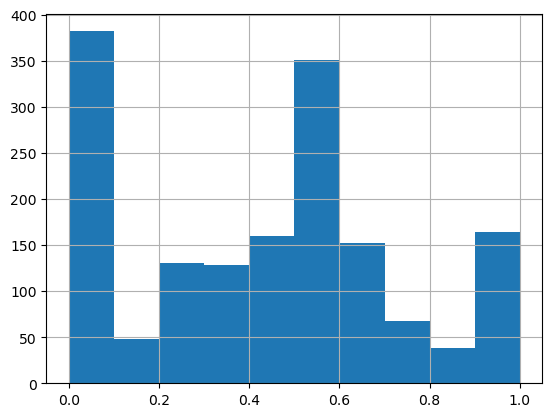

In [21]:
network_classification.is_polyploid_poly_frac.hist()

In [24]:
networks_metadata_path = f"{all_networks_dir}/networks_metadata.csv"
networks_metadata = pd.read_csv(networks_metadata_path)
if "Unnamed: 0" in networks_metadata.columns:
    networks_metadata.drop(["Unnamed: 0"], axis=1)
networks_metadata = networks_metadata.drop_duplicates()
networks_metadata.set_index(["network_type", "network_index"], inplace=True)
network_classification["is_polyploid_poly_frac"] = network_classification["is_polyploid_poly_frac"]
network_classification["is_polyploid_missing_frac"] = network_classification["is_polyploid_missing_frac"]
network_classification.set_index(["network_type", "network_id"], inplace=True)
networks_metadata.fillna(network_classification.reindex(networks_metadata.index), inplace=True)
networks_metadata.reset_index(inplace=True)
network_classification.reset_index(inplace=True)

/tmp/ipykernel_12632/2962338041.py:2: DtypeWarning: Columns (8,9,10,11,12,13,15,16,17,18,19,20,35,37,39,40,41,63,98) have mixed types. Specify dtype option on import or set low_memory=False.
  networks_metadata = pd.read_csv(networks_metadata_path)


In [25]:
networks_metadata.sort_values(["network_type", "network_index"], inplace=True)
networks_metadata.to_csv(networks_metadata_path)

# debug missing values

In [20]:
suspects = plant_classification_df.query("is_polyploid.isna() and resolved_name.isna()").original_name.tolist()

In [21]:
bad_networks = features_by_network.loc[(features_by_network.original_name.isin(suspects)) & (~features_by_network.original_name.str.contains(" "))].drop_duplicates(["network_type","network_id"])
bad_networks = bad_networks.merge(network_classification, on=["network_type", "network_id"], how="left").query("is_polyploid_missing_frac < 1")[["network_id", "network_type"]]

# flag bad networks from features data
flag_name = "multiple_plant_taxonomic_levels"
features_dir="../../data/features/"
features_types = ["plant", "network"]
networks_types = ["binary", "weighted", "binarized_weighted"]
for feature_type in features_types:
    for network_type in  networks_types:
        path = f"{features_dir}/{feature_type}/{network_type}/features.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            relevant_bad_networks = set(bad_networks.query(f"network_type == '{network_type}'").network_id.tolist())
            df[flag_name] = df["network"].apply(lambda i: 1 if i in relevant_bad_networks else 0)
            df.to_csv(path, index=False)

KeyError: 'network'

In [22]:
# update classification of features data
name_to_is_poly = plant_classification_df.set_index("original_name")["is_polyploid"].to_dict()
features_types = ["plant", "network"]
networks_types = ["binary", "weighted", "binarized_weighted"]
all_features_dir="../../data/features/"

features_data = {}

for feature_type in features_types:
    features_data[feature_type] = {}
    for network_type in  networks_types:
        print(f"\n\nfeature type = {feature_type}")
        print(f"network_type = {network_type}")
        features_df = pd.read_csv(f"{all_features_dir}{feature_type}/{network_type}/features.csv")
        print(f"# records = {features_df.shape[0]:,}")
        if feature_type == "plant":
            features_df["original_name"] = features_df.Plant.str.lower()
            features_df["is_polyploid"] = features_df["original_name"].apply(lambda n: name_to_is_poly.get(n, np.nan))
            features_df.loc[features_df.is_polyploid.isna(), "is_polyploid"] = features_df.original_name.apply(lambda n: name_to_is_poly.get(" ".join(n.split(" ")[:2]), np.nan))

            print(f"# classified records = {features_df.is_polyploid.notna().sum():,}")
        else:
            network_query_type = "binary" if network_type=="binary" else "weighted"
            class_df = network_classification.query(f"network_type == '{network_query_type}'")
            features_df["network_id"] = features_df["network"].apply(lambda n: int(n.replace(".csv","")) if type(n) == str else n)
            features_df = features_df.merge(class_df[["network_id", "is_polyploid_poly_frac", "is_polyploid_missing_frac"]],
                                            on="network_id",
                                            how="left").rename(columns={"is_polyploid_poly_frac": "is_polyploid_poly_frac",
                                                                        "is_polyploid_missing_frac": "is_polyploid_missing_frac"})
            print(f"# classified records = {features_df.is_polyploid_poly_frac.notna().sum():,}\n")
            features_data[feature_type][network_type] = features_df
        features_df.to_csv(f"{all_features_dir}/{feature_type}/{network_type}/features_with_classification.csv", index=False)
                                                    



feature type = plant
network_type = binary
# records = 4,608
# classified records = 775


feature type = plant
network_type = weighted
# records = 8,944
# classified records = 4,801


feature type = plant
network_type = binarized_weighted
# records = 9,005
# classified records = 4,803


feature type = network
network_type = binary
# records = 177
# classified records = 177



feature type = network
network_type = weighted
# records = 531
# classified records = 531



feature type = network
network_type = binarized_weighted
# records = 534
# classified records = 534



In [23]:
# add classification to network features files
network_features_dir = "../../data/features/network/"
network_types = ["binary", "weighted", "binarized_weighted"]
for net_type in network_types:
    out_path = f"{network_features_dir}{net_type}/features.csv"
    relevant_network_classification_data = network_classification.loc[network_classification.network_type == net_type.replace("binarized_","")]
    df = pd.read_csv(out_path)
    df.network = df.network.apply(lambda n: int(n.replace('.csv','')) if type(n) == str else n)
    df = df.merge(relevant_network_classification_data, left_on="network", right_on="network_id", how="left")
    df.to_csv(f"{network_features_dir}{net_type}/features_with_classification.csv", index=False)

In [24]:
print(f"# networks with no ploidy classification = {network_classification.loc[network_classification.is_polyploid_missing_frac == 1].shape[0]:,}")
print(f"# networks with some ploidy classification = {network_classification.loc[network_classification.is_polyploid_missing_frac < 1].shape[0]:,}")
print(f"# networks with ploidy classification availablity above 70% = {network_classification.loc[network_classification.is_polyploid_missing_frac <= 0.3].shape[0]:,}")

# networks with no ploidy classification = 178
# networks with some ploidy classification = 723
# networks with ploidy classification availablity above 70% = 286


In [25]:
network_classification.loc[network_classification.is_polyploid_missing_frac < 1].groupby("network_type")["network_id"].count()

network_type
binary       80
weighted    643
Name: network_id, dtype: int64

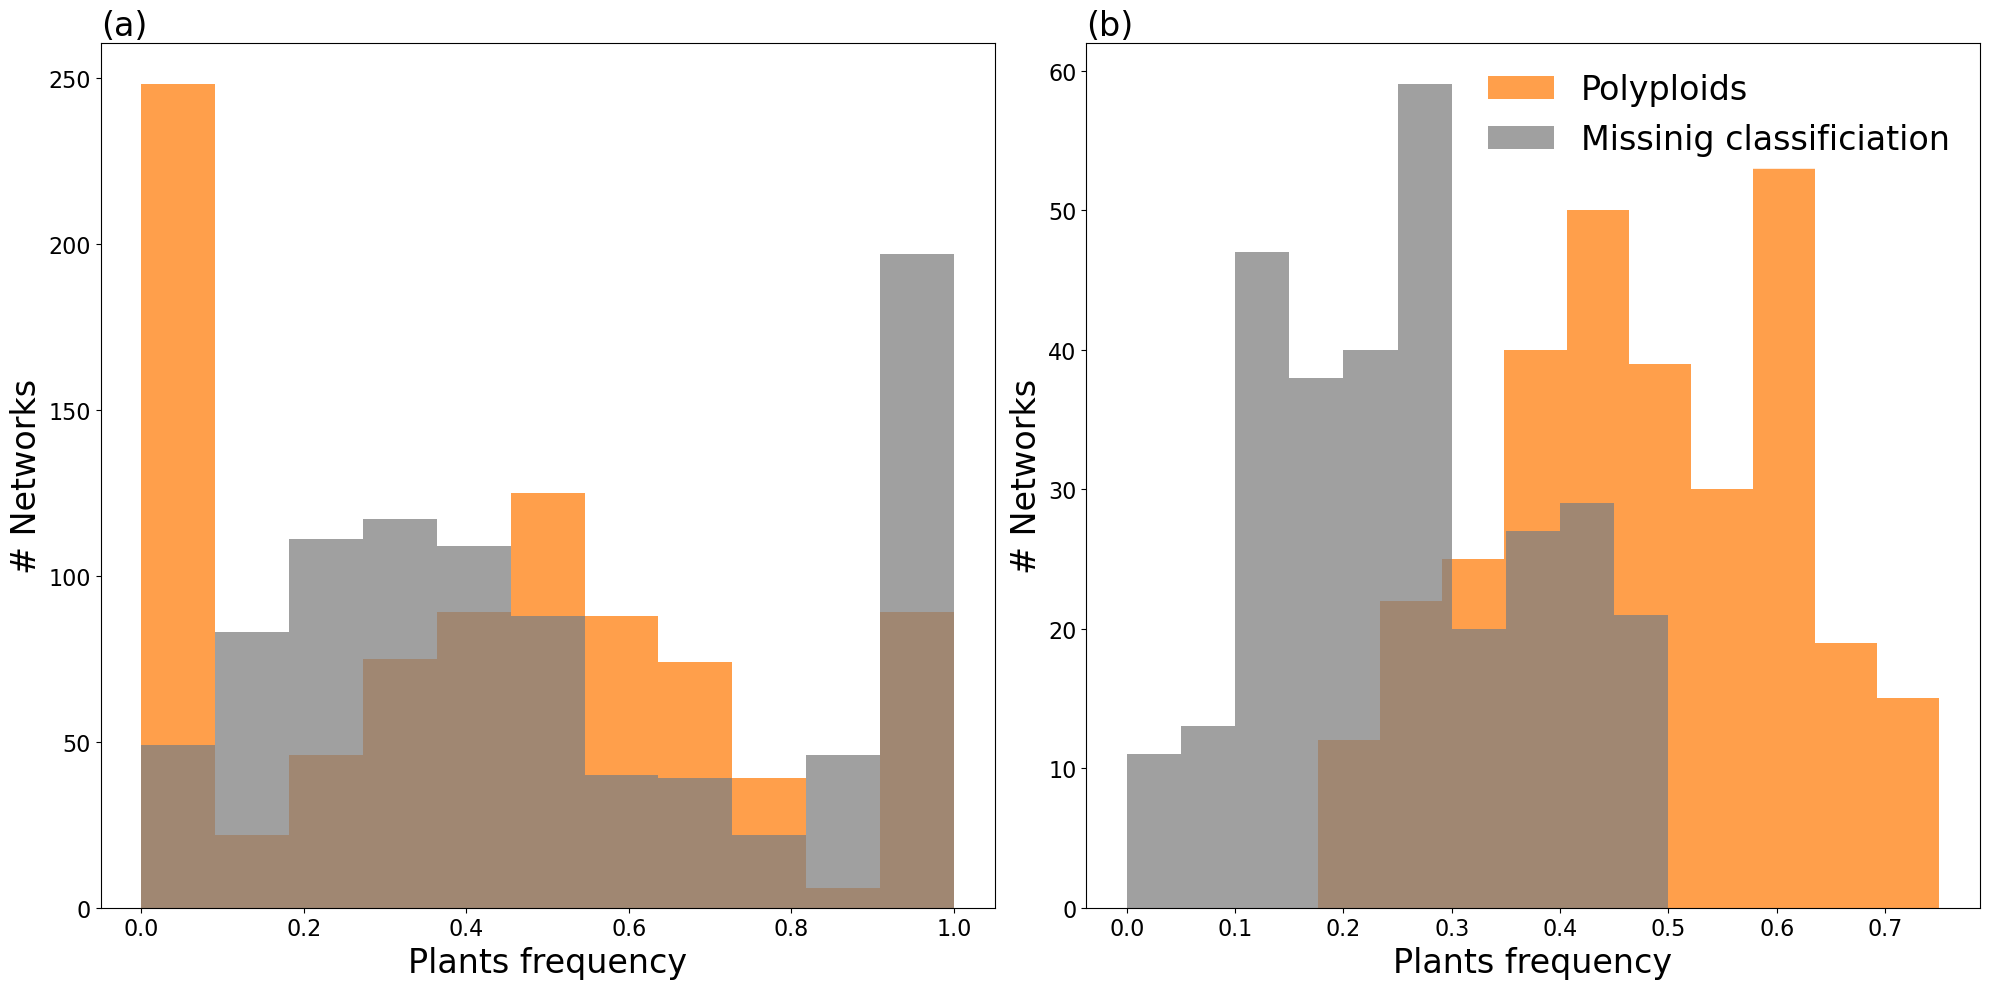

In [26]:
import seaborn as sns
plt.rcParams['patch.linewidth'] = 0
fontsize = 24

max_missing_threshold = 0.5
min_classified_threshold = 5
min_poly_threhold = 2
min_di_threshold = 2

network_level_classification = pd.read_csv(network_classification_path)
filtered_network_level_classification = network_level_classification.loc[(network_level_classification.is_polyploid_missing_frac <= max_missing_threshold) & 
                                                                        (network_level_classification.num_classified >= min_classified_threshold) & 
                                                                        (network_level_classification.num_polyploids >= min_poly_threhold) &
                                                                        (network_level_classification.num_diploids >= min_di_threshold)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

ax = axes[0]
sns.histplot(data=network_level_classification, 
             x="is_polyploid_poly_frac", 
             label="Polyploids",
             color=sns.color_palette()[1],
             ax=ax)

sns.histplot(data=network_level_classification, 
             x="is_polyploid_missing_frac", 
             label="Missinig classificiation",
             color="grey",
             ax=ax)
ax.set_title("(a)", loc="left", fontsize=fontsize)
ax.set_ylabel("# Networks", fontsize=fontsize)
ax.set_xlabel("Plants frequency", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax = axes[1]
sns.histplot(data=filtered_network_level_classification, 
             x="is_polyploid_poly_frac", 
             label="Polyploids",
             color=sns.color_palette()[1],
             ax=ax)

sns.histplot(data=filtered_network_level_classification, 
             x="is_polyploid_missing_frac", 
             label="Missinig classificiation",
             color="grey",
             ax=ax)
ax.set_title("(b)", loc="left", fontsize=fontsize)

ax.legend(fontsize=fontsize)
ax.set_ylabel("# Networks", fontsize=fontsize)
ax.set_xlabel("Plants frequency", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

fig.tight_layout()
fig.savefig("../../data/figures/figS1.jpeg")

In [27]:
network_classification["path"] = network_classification.apply(lambda rec: f"../../data/networks/all/{rec.network_type}/{rec.network_id}.csv", axis=1)
network_classification["num_pollinators"] = network_classification.path.apply(lambda path: pd.read_csv(path).shape[1]-1)

In [28]:
network_classification.to_csv(network_classification_path)

In [29]:
networks_for_analysis = network_classification.loc[network_classification.is_polyploid_missing_frac < 1]
print(f"# networks for analysis = {networks_for_analysis.shape[0]:,}")
print(f"# plant vertices in networks for analysis = {networks_for_analysis.num_plants.sum():,}")
print(f"# resolved plants in networks for analysis = {networks_for_analysis.num_resolved.sum():,}")
print(f"# classified plants in networks for analysis = {networks_for_analysis.num_classified.sum():,}")
print(f"# diploid plants in networks for analysis = {networks_for_analysis.num_diploids.sum():,}")
print(f"# polyploid plants in networks for analysis = {networks_for_analysis.num_polyploids.sum():,}")
print(f"# pollinator vertices = {networks_for_analysis.num_pollinators.sum():,}")

# networks for analysis = 723
# plant vertices in networks for analysis = 11,341
# resolved plants in networks for analysis = 6,200
# classified plants in networks for analysis = 6,160
# diploid plants in networks for analysis = 3,400
# polyploid plants in networks for analysis = 2,760
# pollinator vertices = 30,112


In [30]:
plants, pollinators = [], []
for path in networks_for_analysis["path"].values:
    net = pd.read_csv(path)
    if "Plant" not in net.columns:
        net = net.rename(columns={"Unnamed: 0": "Plant"})
    plants += net.Plant.str.capitalize().tolist()
    pollinators += net.set_index("Plant").columns.tolist()
print(f"# plants = {len(plants):,}, # unique plants = {len(set(plants)):,}")
print(f"# pollinators = {len(pollinators):,}, # unique pollinators = {len(set(pollinators)):,}")

# plants = 11,341, # unique plants = 3,926
# pollinators = 30,112, # unique pollinators = 12,336


In [31]:
plants = list(set(plants))
pollinators = list(set(pollinators))

resolved_plants_data = pd.read_csv(resolved_plant_names_path)
resolved_pollinator_data = pd.read_csv(resolved_pollinator_names_path)

In [32]:
resolved_plants = resolved_plants_data.loc[resolved_plants_data.original_name.str.capitalize().isin(plants)].original_name.unique().tolist()
classified_plants = plant_classification.loc[plant_classification.original_name.isin(resolved_plants)].dropna(subset=["is_polyploid_by_resolved"]).original_name.unique().tolist()
resolved_pollinators = resolved_pollinator_data.loc[resolved_pollinator_data.original_name.str.capitalize().isin(pollinators)].original_name.unique().tolist()

print(f"# resolved plants = {len(resolved_plants):,}, # classified plants = {len(classified_plants):,}")
print(f"# resolved pollinators = {len(resolved_pollinators):,}")

# resolved plants = 3,533, # classified plants = 1,665
# resolved pollinators = 5,962
